In [ ]:
import requests
import json
import numpy as np
import pandas as pd
import nltk 
import matplotlib
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
from string import punctuation
import re
import numpy as np
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer

In [ ]:
url = 'https://newsapi.org/v2/everything?'
api_key = "c31d9f572e5d47eeaae9d16463d0c921"

In [ ]:
def get_articles(file):
    '''
    This is a helper function the extract articles from the newsapi dataset
    ''' 


    article_results = [] 
    for i in range(len(file)):
        article_dict = {}
        article_dict['title'] = file[i]['title']
        article_dict['author'] = file[i]['author']
        article_dict['source'] = file[i]['source']
        article_dict['description'] = file[i]['description']
        article_dict['content'] = file[i]['content']
        article_dict['pub_date'] = file[i]['publishedAt']
        article_dict['url'] = file[i]["url"]
        article_dict['photo_url'] = file[i]['urlToImage']
        article_results.append(article_dict)
    return article_results

def get_news_articles(source: str, topic: str):
    '''
    Returns the dataframe from newsource and topic
    Input: str,str
    Output: pd frame
    '''

    assert isinstance(source,str)
    assert isinstance(topic,str)

    
    parameters_headlines = {
    'q': topic,
    'sortBy':'popularity',
    'pageSize': 100,
    'apiKey': api_key,
    'language': 'en',
    'domains' : format(source)  
    }

    # making the API call 
    response_headline = requests.get(url, params = parameters_headlines)
    response_json_headline = response_headline.json()
    responses = response_json_headline["articles"]
    # transforminf the data from JSON dictionary to a pandas data frame
    news_articles_df = pd.DataFrame(get_articles(responses))
    # printing the head to check the format and the working of the get_articles function
    return news_articles_df

In [ ]:
cnn_f = get_news_articles("cnn.com","biden")     #cnn covid frame
fox_f = get_news_articles("foxnews.com","biden") #fox covid frame

In [ ]:
def get_senti_frame(frame = None, download = False):

    '''
    Returns a dataframe with sentiment scores extracted using nltk vader
    Input: pd frame, bool
    Output: pd frame
    '''
    
    assert isinstance(download,bool)

    from nltk.sentiment.vader import SentimentIntensityAnalyzer as SIA
    if(download):nltk.download('vader_lexicon')
    sia = SIA()
    results = []
    titles = frame["title"]

    for line in titles:
        pol_score = sia.polarity_scores(line)
        pol_score['headline'] = line
        results.append(pol_score)
    
    df = pd.DataFrame.from_records(results)
    df['label'] = 0
    df.loc[df['compound'] > 0.2, 'label'] = 1
    df.loc[df['compound'] < -0.2, 'label'] = -1
    return df

In [ ]:
cnn_sframe = get_senti_frame(cnn_f,True)
fox_sframe = get_senti_frame(fox_f,False)

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


/usr/local/lib/python3.7/dist-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


Here we show the processed sentiment dataframe, where 0 represents neutral, -1 represents negative, and 1 represents postive. Sentiment were calculated based on the headlines of the news

In [ ]:
cnn_sframe.head()

,neg,neu,pos,compound,headline,label
0,0.000,1.000,0.000,0.0000,In pictures: Biden's second foreign trip as Pr...,0
1,0.554,0.446,0.000,-0.8271,Biden administration blames ongoing pandemic f...,-1
2,0.124,0.876,0.000,-0.1779,Lawmakers puzzled that Biden is yet to name no...,0
3,0.000,0.588,0.412,0.6808,Analysis: What the polls agree on about Biden'...,1
4,0.104,0.896,0.000,-0.1027,CIA director dispatched to Moscow to warn Russ...,0


Next, we show some samples of the postively labeled  ande negative sentiment headlines

In [ ]:
positive_cnn = cnn_sframe[cnn_sframe["label"] == 1]["headline"]
print(positive_cnn.iloc[0])
print(positive_cnn.iloc[2])
print(positive_cnn.iloc[5])

Analysis: What the polls agree on about Biden's approval rating
Opinion: Democrats better build an ark
136 Countries agree to minimum corporate tax rate


In [ ]:
positive_cnn = cnn_sframe[cnn_sframe["label"] == -1]["headline"]
print(positive_cnn.iloc[0])
print(positive_cnn.iloc[2])
print(positive_cnn.iloc[5])

Biden administration blames ongoing pandemic fears for disappointing jobs report
Biden says he's considering deploying the National Guard to ease supply chain crisis
In pictures: Supply chain problems in the US


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot(df,title:str):
    '''
      Given a sentiment frame, plot the sentiment
    '''
  
    assert isinstance(title,str)

    fig, ax = plt.subplots(figsize=(8, 8))

    counts = df.label.value_counts(normalize=True) * 100

    sns.barplot(x=counts.index, y=counts, ax=ax)

    ax.set_xticklabels(['Negative', 'Neutral', 'Positive'])
    ax.set_ylabel("Percentage")
    ax.set_title(title)
    plt.show()

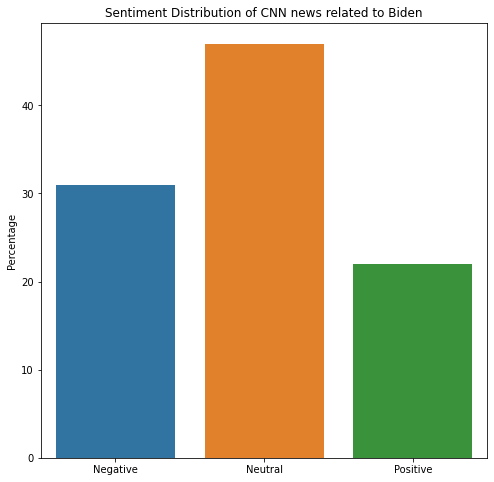

In [ ]:
plot(cnn_sframe,"Sentiment Distribution of CNN news related to Biden")

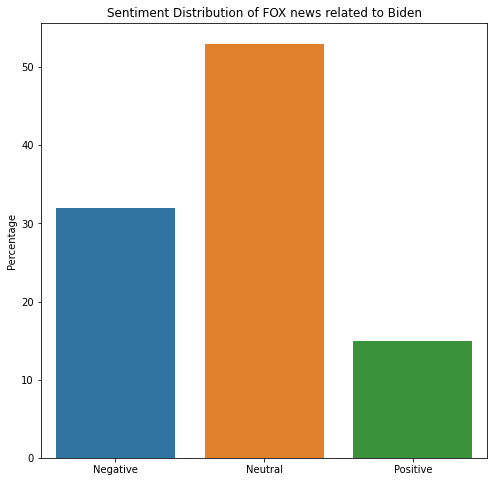

In [ ]:
plot(fox_sframe,"Sentiment Distribution of FOX news related to Biden")

In [ ]:
def get_word_freq(sframe,label,topk = 20,download = False):
    '''
    Returns the top words in the headlines given the label{1(pos), -1(negative)}
    Input: data frame,data frame, int, int, bool
          sframe: sentiment frame, df: news dataframe
    Output: list of dict 
    '''

    assert isinstance(label,int)
    assert isinstance(download,bool)

    from nltk.corpus import stopwords
    from nltk.tokenize import word_tokenize, RegexpTokenizer
    tokenizer = RegexpTokenizer(r'\w+')
    if download: nltk.download('stopwords')

    stop_words = stopwords.words('english')
    tokens = []


    pos_lines = list(sframe[sframe.label == label].headline)

    for line in pos_lines:
        toks = tokenizer.tokenize(line)
        toks = [t.lower() for t in toks if t.lower() not in stop_words]
        tokens.extend(toks)
    
    pos_freq = nltk.FreqDist(tokens)
    return pos_freq.most_common(topk) if topk is not None else pos_freq.most_common()

    

In [ ]:
cnn_pos = get_word_freq(cnn_sframe,label = 1, topk = None,download = True)
print(cnn_pos[:20])
cnn_neg = get_word_freq(cnn_sframe,label = -1, topk = None)
print(cnn_neg[:20])

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[('biden', 10), ('opinion', 3), ('says', 3), ('agree', 2), ('trump', 2), ('era', 2), ('november', 2), ('better', 2), ('build', 2), ('us', 2), ('pope', 2), ('climate', 2), ('democratic', 2), ('analysis', 1), ('polls', 1), ('approval', 1), ('rating', 1), ('administration', 1), ('preparing', 1), ('revive', 1)]
[('biden', 6), ('us', 6), ('6', 4), ('says', 3), ('supply', 3), ('chain', 3), ('crisis', 3), ('house', 3), ('trump', 3), ('january', 3), ('climate', 3), ('taiwan', 3), ('democrats', 3), ('agenda', 3), ('pictures', 2), ('white', 2), ('former', 2), ('chief', 2), ('could', 2), ('committee', 2)]


In [ ]:
fox_pos = get_word_freq(fox_sframe,label = 1, topk = None)
print(cnn_pos[:20])
fox_neg = get_word_freq(fox_sframe,label = -1, topk = None)
print(cnn_neg[:20])

[('biden', 10), ('opinion', 3), ('says', 3), ('agree', 2), ('trump', 2), ('era', 2), ('november', 2), ('better', 2), ('build', 2), ('us', 2), ('pope', 2), ('climate', 2), ('democratic', 2), ('analysis', 1), ('polls', 1), ('approval', 1), ('rating', 1), ('administration', 1), ('preparing', 1), ('revive', 1)]
[('biden', 6), ('us', 6), ('6', 4), ('says', 3), ('supply', 3), ('chain', 3), ('crisis', 3), ('house', 3), ('trump', 3), ('january', 3), ('climate', 3), ('taiwan', 3), ('democrats', 3), ('agenda', 3), ('pictures', 2), ('white', 2), ('former', 2), ('chief', 2), ('could', 2), ('committee', 2)]


In [ ]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt

In [ ]:
pos_h_cnn = cnn_sframe[cnn_sframe["label"]==1]["headline"].tolist() 
pos_h_fox = cnn_sframe[fox_sframe["label"]==1]["headline"].tolist() 
neg_h_cnn = cnn_sframe[cnn_sframe["label"]==-1]["headline"].tolist() 
neg_h_fox = cnn_sframe[fox_sframe["label"]==-1]["headline"].tolist() 

In [ ]:
 pos_wc_cnn = WordCloud(width = 800, height = 800,
                background_color ='white',
                stopwords = set(STOPWORDS),
                min_font_size = 10).generate(" ".join(pos_h_cnn))
 neg_wc_cnn = WordCloud(width = 800, height = 800,
                background_color ='white',
                stopwords = set(STOPWORDS),
                min_font_size = 10).generate(" ".join(neg_h_cnn))
pos_wc_fox = WordCloud(width = 800, height = 800,
                background_color ='white',
                stopwords = set(STOPWORDS),
                min_font_size = 10).generate(" ".join(pos_h_fox))
neg_wc_fox = WordCloud(width = 800, height = 800,
                background_color ='white',
                stopwords = set(STOPWORDS),
                min_font_size = 10).generate(" ".join(neg_h_fox))

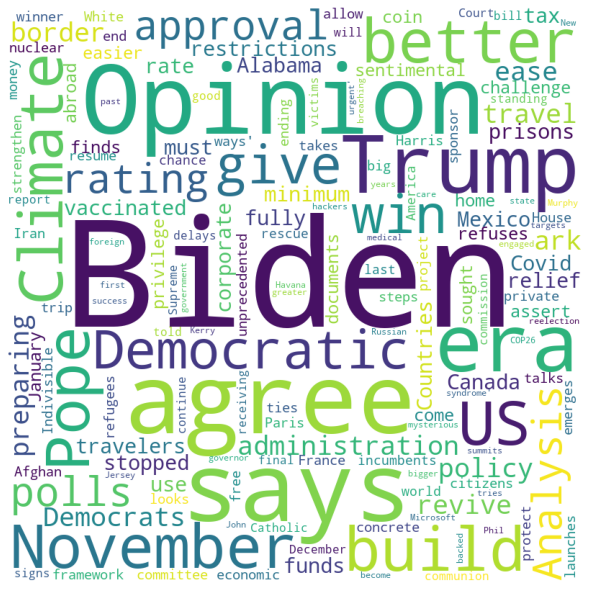

In [ ]:
# plot the WordCloud image                      
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(pos_wc_cnn)
plt.axis("off")
plt.tight_layout(pad = 0)
 
plt.show()

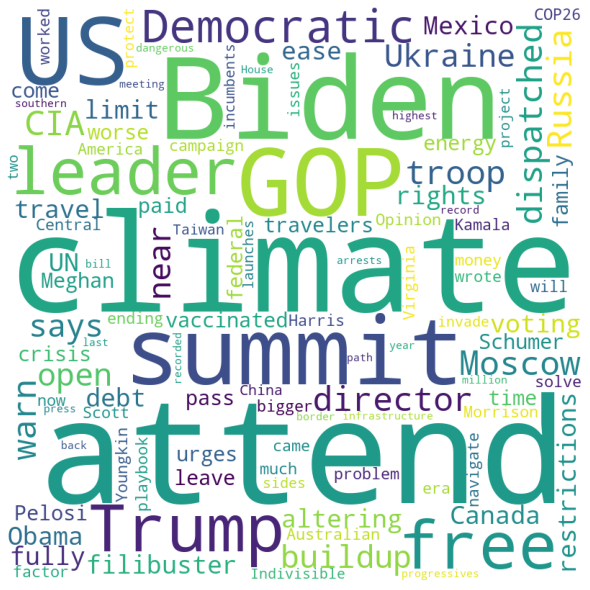

In [ ]:
# plot the WordCloud image                      
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(pos_wc_fox)
plt.axis("off")
plt.tight_layout(pad = 0)
 
plt.show()

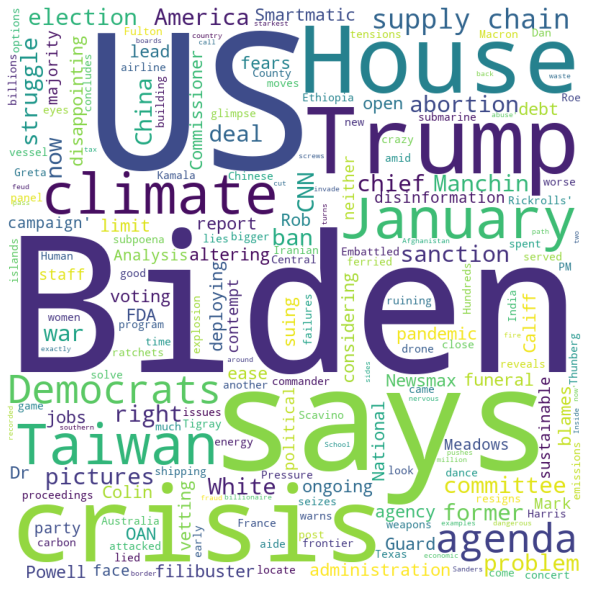

In [ ]:
# plot the WordCloud image                      
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(neg_wc_cnn)
plt.axis("off")
plt.tight_layout(pad = 0)
 
plt.show()

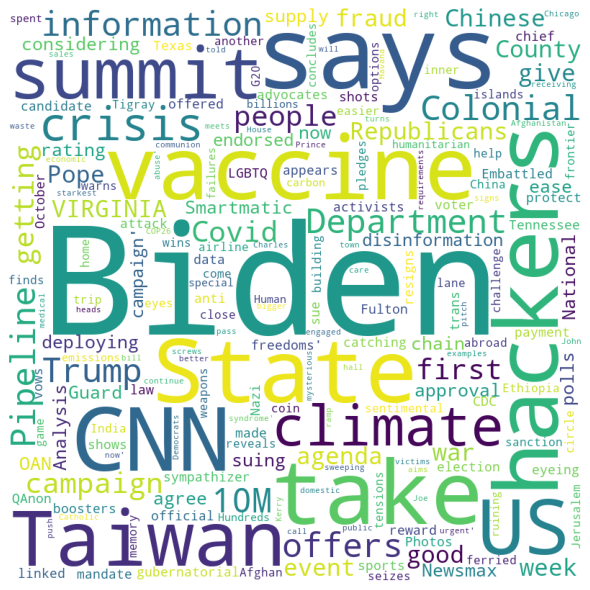

In [ ]:
# plot the WordCloud image                      
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(neg_wc_fox)
plt.axis("off")
plt.tight_layout(pad = 0)
 
plt.show()